# Purpose


**2022-11-09**: 
<br>Make some changes on filtering logic. Add new filtering logic.
Besides excluding subreddits that have too few posts, we also want to exclude subreddits that are not active enough. "active enough" is defined by `seed` subreddit column. So we'll do a 2-step filter:
- Exclude subreddits with too few posts
- Exclude subreddits below activity threshold


2022-07-05: Run **subreddit-level** clustering jobs in parallel with `hydra`.



# Imports & Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
import logging
import os
from pathlib import Path

import numpy as np
import pandas as pd
import plotly
import seaborn as sns

import mlflow
import hydra

import subclu
from subclu.eda.aggregates import compare_raw_v_weighted_language
from subclu.utils import set_working_directory, get_project_subfolder
from subclu.utils.eda import (
    setup_logging, counts_describe, value_counts_and_pcts,
    notebook_display_config, print_lib_versions,
    style_df_numeric, reorder_array,
)
from subclu.utils.mlflow_logger import MlflowLogger
from subclu.utils.hydra_config_loader import LoadHydraConfig
from subclu.utils.data_irl_style import (
    get_colormap, theme_dirl, 
    get_color_dict, base_colors_for_manual_labels,
    check_colors_used,
)
from subclu.data.data_loaders import LoadPosts, LoadSubreddits, create_sub_level_aggregates


# ===
# imports specific to this notebook
from collections import Counter
# import umap
# import openTSNE
# from openTSNE import TSNE

# import hdbscan

import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize  # if we normalize the data, euclidean distance is approx of cosine

from sklearn.cluster import KMeans, DBSCAN, OPTICS, AgglomerativeClustering

from subclu.models.clustering import ClusterEmbeddings
from subclu.models.clustering_utils import plot_elbow_and_get_k


print_lib_versions([hydra, np, pd, plotly, sklearn, sns, subclu])

python		v 3.7.10
===
hydra		v: 1.1.0
numpy		v: 1.19.5
pandas		v: 1.2.4
plotly		v: 4.14.3
sklearn		v: 0.24.1
seaborn		v: 0.11.1
subclu		v: 0.6.1


In [3]:
# plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
plt.style.use('default')

setup_logging()
notebook_display_config()

# Set sqlite database as MLflow URI

In [4]:
# use new class to initialize mlflow
mlf = MlflowLogger(tracking_uri='sqlite')
mlflow.get_tracking_uri()

'sqlite:////home/jupyter/subreddit_clustering_i18n/mlflow_sync/djb-100-2021-04-28-djb-eda-german-subs/mlruns.db'

## Get list of experiments with new function

In [5]:
mlf.list_experiment_meta(output_format='pandas').tail(9)

,experiment_id,name,artifact_location,lifecycle_stage
35,35,v0.6.0_mUSE_aggregates,gs://i18n-subreddit-clustering/mlflow/mlruns/35,active
36,36,v0.6.0_mUSE_clustering_test,gs://i18n-subreddit-clustering/mlflow/mlruns/36,active
37,37,v0.6.0_mUSE_clustering,gs://i18n-subreddit-clustering/mlflow/mlruns/37,active
38,38,v0.6.0_nearest_neighbors,gs://i18n-subreddit-clustering/mlflow/mlruns/38,active
39,39,v0.6.1_mUSE_aggregates_test,gs://i18n-subreddit-clustering/mlflow/mlruns/39,active
40,40,v0.6.1_mUSE_aggregates,gs://i18n-subreddit-clustering/mlflow/mlruns/40,active
41,41,v0.6.1_mUSE_clustering_test,gs://i18n-subreddit-clustering/mlflow/mlruns/41,active
42,42,v0.6.1_mUSE_clustering,gs://i18n-subreddit-clustering/mlflow/mlruns/42,active
43,43,v0.6.1_nearest_neighbors,gs://i18n-subreddit-clustering/mlflow/mlruns/43,active


## Get experiment IDs to use for clustering

Pick an embeddings run that covers the subreddits we want to cluster.

for v0.6.1:
`91ac7ca171024c779c0992f59470c81b`

In [6]:
%%time

df_mlf = mlf.search_all_runs(experiment_ids=[40])
df_mlf.shape

CPU times: user 64.5 ms, sys: 35.1 ms, total: 99.6 ms
Wall time: 1.67 s


(4, 43)

In [7]:
df_mlf.iloc[:5, :13]

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.memory_used_percent,metrics.df_v_post_comments-cols,metrics.df_v_subs-cols,metrics.df_v_subs-rows,metrics.time_fxn-data_loading_time,metrics.memory_free,metrics.memory_used
0,2695f87ed3a14caa8e87ba572ad49782,40,RUNNING,gs://i18n-subreddit-clustering/mlflow/mlruns/40/2695f87ed3a14caa8e87ba572ad49782/artifacts,2022-11-08 07:07:09.216000+00:00,NaT,0.869350,515.0,514.0,781653.0,31.426165,150879.0,1256177.0
1,8519652dc1aa46c0b49911bb04cf7ffe,40,RUNNING,gs://i18n-subreddit-clustering/mlflow/mlruns/40/8519652dc1aa46c0b49911bb04cf7ffe/artifacts,2022-11-08 03:51:17.460000+00:00,NaT,0.497697,515.0,514.0,781653.0,4.531167,759036.0,719153.0
2,91ac7ca171024c779c0992f59470c81b,40,FINISHED,gs://i18n-subreddit-clustering/mlflow/mlruns/40/91ac7ca171024c779c0992f59470c81b/artifacts,2022-11-07 21:38:57.662000+00:00,2022-11-18 17:15:40.666000+00:00,0.552656,515.0,514.0,781653.0,5.742884,1283359.0,798566.0
3,f7f796e6dc054b3f89027a5027ac227a,40,RUNNING,gs://i18n-subreddit-clustering/mlflow/mlruns/40/f7f796e6dc054b3f89027a5027ac227a/artifacts,2022-11-07 19:00:30.584000+00:00,NaT,0.001309,NaN,514.0,781653.0,NaN,1441183.0,1892.0


In [8]:
# mask_finished = df_mlf['status'] == 'FINISHED'
# mask_df_similarity_complete = ~df_mlf['metrics.df_sub_level_agg_a_post_only_similarity-rows'].isnull()

# df_mlf_clustering_candidates = df_mlf[mask_finished & mask_df_similarity_complete]
# df_mlf_clustering_candidates.shape

In [9]:
# cols_with_multiple_vals = df_mlf_clustering_candidates.columns[df_mlf_clustering_candidates.nunique(dropna=False) > 1]

# df_mlf_clustering_candidates[cols_with_multiple_vals]

# Inspect config for clustering job

This config should include:
- data to load for clustering
- parameters for clustering algo
- hydra overrides to run jobs in parallel

In [46]:
test_experiment = 'v0.6.1_mUSE_clustering_test'

config_name = 'clustering_v0.6.1_subreddit_base.yaml'

cfg_cluster_test = LoadHydraConfig(
    config_name=config_name,
    config_path="../config",
    overrides=[
        f"mlflow_experiment_name={test_experiment}"
#         f"data_text_and_metadata=top_subreddits_2021_07_16",
#         f"data_embeddings_to_cluster=top_subs-2021_07_16-use_multi_lower_case_false_00",
    ],
)

print([k for k in cfg_cluster_test.config_dict.keys()])

['data_text_and_metadata', 'data_embeddings_to_cluster', 'clustering_algo', 'embeddings_to_cluster', 'n_sample_embedding_rows', 'n_max_clusters_to_check_for_optimal_k', 'filter_embeddings', 'mlflow_tracking_uri', 'mlflow_experiment_name', 'pipeline_config']


In [37]:
cfg_cluster_test.config_dict['n_max_clusters_to_check_for_optimal_k']

8000

In [38]:
# data with text/meta
cfg_cluster_test.config_dict['data_text_and_metadata']

{'dataset_name': 'v0.6.1 inputs. ~110k seed subreddits, ~340k with 3+ posts, ~700k total subreddits',
 'bucket_name': 'i18n-subreddit-clustering',
 'folder_subreddits_text_and_meta': 'i18n_topic_model_batch/runs/20221107/subreddits_fix/text',
 'folder_subreddits_text_and_meta_crowd_topic': 'i18n_topic_model_batch/runs/20221107/subreddits/text',
 'folder_posts_text_and_meta': 'i18n_topic_model_batch/runs/20221107/posts',
 'folder_comments_text_and_meta': 'i18n_topic_model_batch/runs/20221107/comments',
 'folder_post_and_comment_text_and_meta': 'i18n_topic_model_batch/runs/20221107/post_and_comment_text_combined/text_all'}

In [39]:
# data with embeddings
cfg_cluster_test.config_dict['data_embeddings_to_cluster']

{'config_description': 'v0.6.1 config for embeddings. C1= Post & comment text were combined and created as single embedding (no averaging).',
 'run_uuid': '91ac7ca171024c779c0992f59470c81b',
 'l_ix_sub': ['subreddit_name', 'subreddit_id'],
 'l_ix_post': ['subreddit_name', 'post_id'],
 'df_post_level_agg_b_post_and_comments': None,
 'df_post_level_agg_c_post_comments_sub_desc': None,
 'df_post_level_agg_c1_post_comments_sub_desc': 'df_posts_agg_c1',
 'df_sub_level_agg_a_post_only': None,
 'df_sub_level_agg_b_post_and_comments': None,
 'df_sub_level_agg_c_post_comments_and_sub_desc': None,
 'df_sub_level_agg_c1_post_comments_and_sub_desc': 'df_subs_agg_c1'}

In [40]:
# clustering algo
cfg_cluster_test.config_dict['clustering_algo']

{'model_name': 'AgglomerativeClustering',
 'connectivity_graph': {'add_step': False,
  'name': 'kneighbors_graph',
  'kwargs': {'n_neighbors': 30,
   'mode': 'connectivity',
   'metric': 'cosine',
   'include_self': False,
   'n_jobs': 10}},
 'model_kwargs': {'n_clusters': 65,
  'affinity': 'euclidean',
  'linkage': 'ward',
  'compute_distances': True,
  'compute_full_tree': True}}

In [41]:
# filtering for embeddings
cfg_cluster_test.config_dict['filter_embeddings']

{'filter_subreddits': {'filter_column': 'posts_for_embeddings_count',
  'minimum_column_value': 4},
 'filter_active_subreddits': {'filter_column': 'subreddit_seed_for_clusters',
  'val_to_keep': True}}

# Run as python fnx

17:16:17 | INFO | "== Start run_aggregation() method =="
17:16:17 | INFO | "MLflow tracking URI: sqlite:////home/jupyter/subreddit_clustering_i18n/mlflow_sync/djb-100-2021-04-28-djb-eda-german-subs/mlruns.db"
17:16:17 | INFO | "=== START CLUSTERING - Process ID 3703"
17:16:17 | INFO | "host_name: djb-100-2021-04-28-djb-eda-german-subs"
17:16:17 | INFO | "cpu_count: 96"
17:16:18 | INFO | "RAM stats:
{'memory_used_percent': '0.22%', 'memory_total': '1,444,961', 'memory_used': '3,119', 'memory_free': '1,437,691'}"
17:16:18 | INFO | "  Local model saving directory: /home/jupyter/subreddit_clustering_i18n/data/models/cluster_embeddings/2022-11-22_171618-embedding_clustering"
17:16:18 | INFO | "  Saving config to local path..."
17:16:18 | INFO | "  Logging config to mlflow with joblib..."
17:16:21 | INFO | "  Logging config to mlflow with YAML..."
17:16:22 | INFO | "Creating pipeline..."
17:16:22 | INFO | "Checking custom pipeline config...
  {'normalize': {'add_step': True, 'name': 'Normali

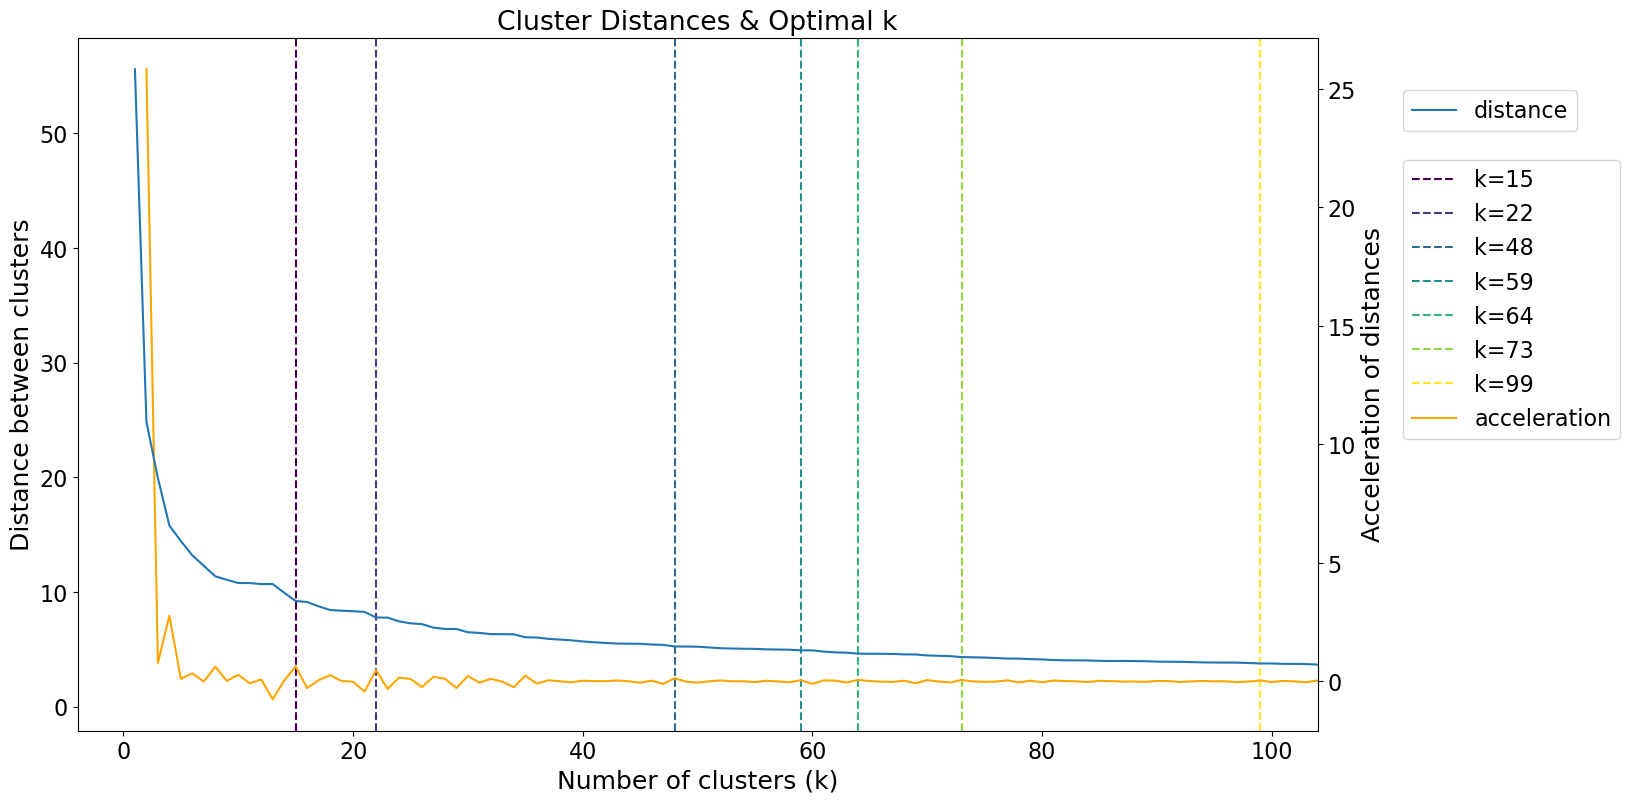

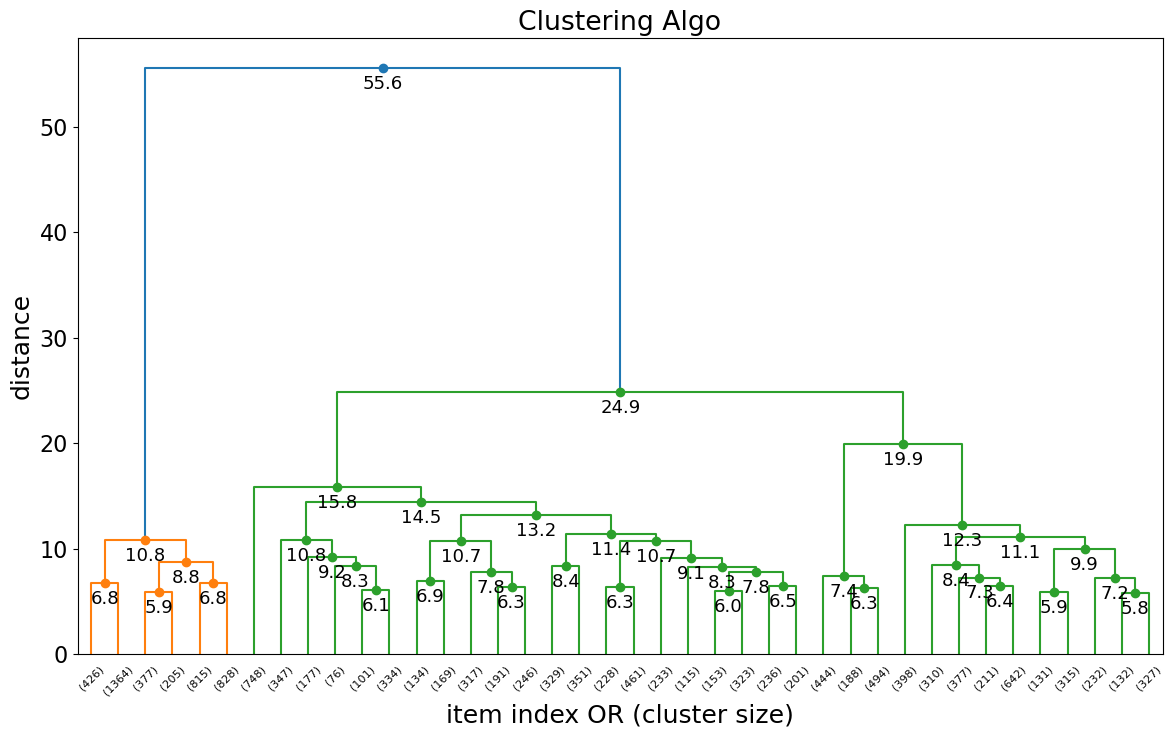

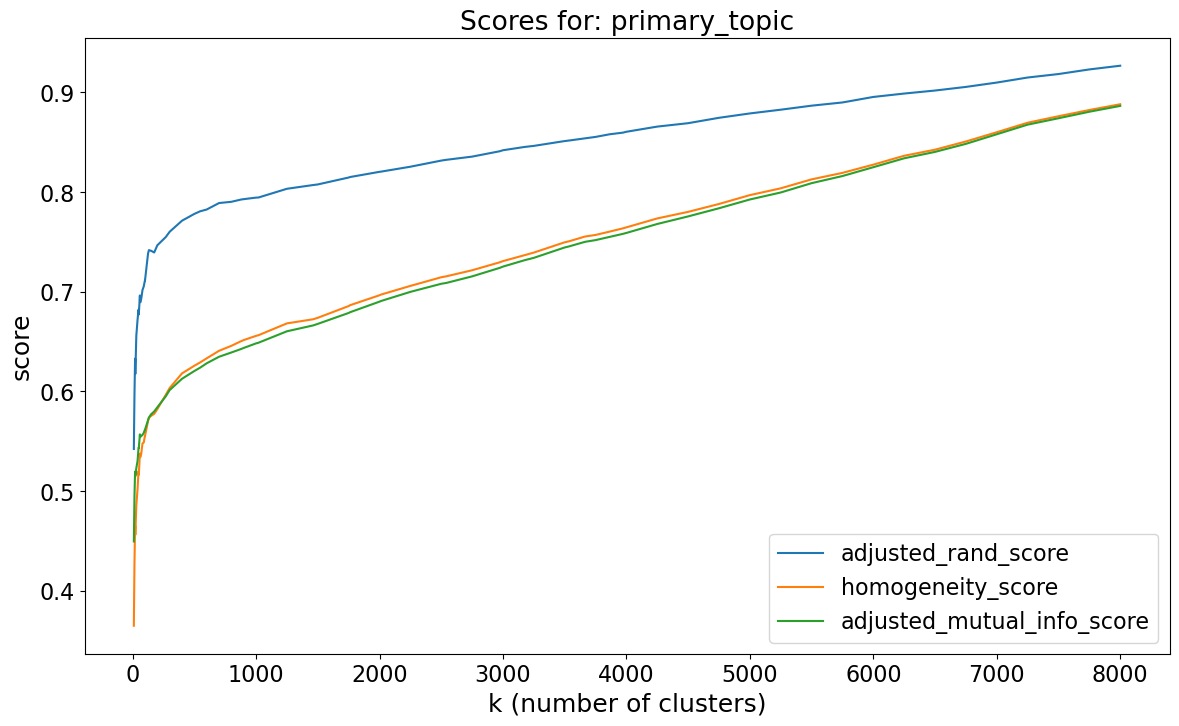

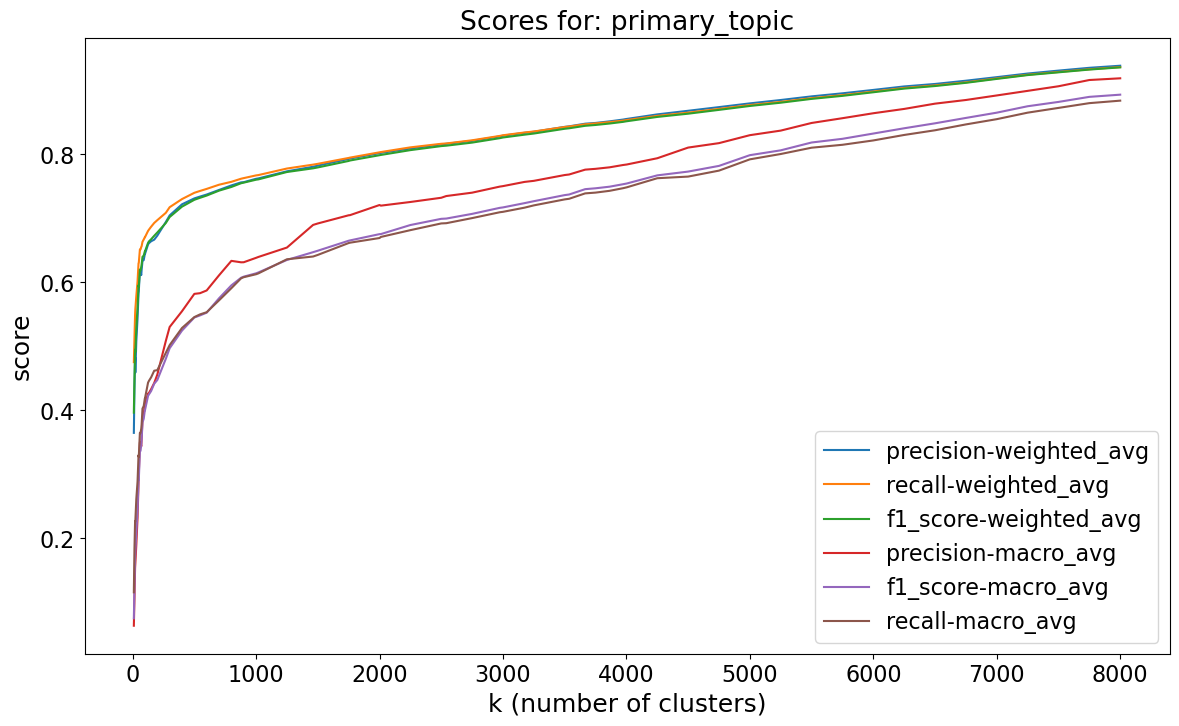

17:18:40 | INFO | "  0:02:22.931492 <- Total Clustering fxn time time elapsed"
17:18:40 | INFO | "--- END clustering metrics---"
17:18:40 | INFO | "  Uploading logs to mlflow..."
17:18:40 | INFO | "RAM stats:
{'memory_used_percent': '0.25%', 'memory_used': '3,621'}"
17:18:40 | INFO | "    Removing fileHandler..."
17:18:40 | INFO | "=== END clustering full job ==="


CPU times: user 1min 43s, sys: 12.7 s, total: 1min 56s
Wall time: 2min 24s


In [43]:
%%time

# use ** to over-ride config defaults
cls_test = ClusterEmbeddings(
    **{
        **cfg_cluster_test.config_dict,
        **{
            'n_sample_embedding_rows': 100000,
            'mlflow_experiment_name': test_experiment,
        }
    }
)

cls_test.run_clustering()

# Run commmand line fxn

The clustering fxn is in `subclu.models.conlustering.py`

Notes:
- We need to use the `-m` flag to run as a submodule (and allow relative imports)
- When using the `-m` flag, REMOVE the `.py` ending of the file!
- In the command line for hydra we can override w/o having to use the `+` sign.
    - https://hydra.cc/docs/tutorials/basic/your_first_app/config_file

## Check & set paths

In [44]:
test_experiment

'v0.6.1_mUSE_clustering_test'

In [45]:
os.getcwd()

'/home/jupyter/subreddit_clustering_i18n/notebooks/v0.6.1'

In [48]:
path_djb_repo = '/home/david.bermejo/repos/subreddit_clustering_i18n/' 
path_djb_models = '/home/david.bermejo/repos/subreddit_clustering_i18n/subclu/models' 
file_clustering_py = 'subclu.models.clustering'


## Run clustering from CLI

```bash
!cd $path_djb_repo && python -m $file_clustering_py \
    mlflow_experiment_name=$test_experiment \
    n_sample_embedding_rows=4000 \
    filter_embeddings.filter_subreddits.minimum_column_value=9
```

In [49]:
file_clustering_py

'subclu.models.clustering'

In [50]:
config_name

'clustering_v0.6.1_subreddit_base.yaml'

In [51]:
# run on sample data, test experiment

!cd $path_djb_repo && python -m $file_clustering_py \
    --config-name $config_name \
    mlflow_experiment_name=$test_experiment \
    n_sample_embedding_rows=90000 \
    pipeline_config.reduce.add_step=true \
    filter_embeddings.filter_subreddits.minimum_column_value=5

CFG keys: dict_keys(['data_text_and_metadata', 'data_embeddings_to_cluster', 'clustering_algo', 'embeddings_to_cluster', 'n_sample_embedding_rows', 'n_max_clusters_to_check_for_optimal_k', 'filter_embeddings', 'mlflow_tracking_uri', 'mlflow_experiment_name', 'pipeline_config'])
`2022-11-22 17:21:27,392` | `INFO` | `Define cluster class...`
`2022-11-22 17:21:28,477` | `INFO` | `== Start run_aggregation() method ==`
`2022-11-22 17:21:28,478` | `INFO` | `MLflow tracking URI: sqlite:////home/jupyter/subreddit_clustering_i18n/mlflow_sync/djb-100-2021-04-28-djb-eda-german-subs/mlruns.db`
`2022-11-22 17:21:28,697` | `INFO` | `=== START CLUSTERING - Process ID 12726`
`2022-11-22 17:21:28,786` | `INFO` | `host_name: djb-100-2021-04-28-djb-eda-german-subs`
`2022-11-22 17:21:28,786` | `INFO` | `cpu_count: 96`
`2022-11-22 17:21:28,871` | `INFO` | `RAM stats:
{'memory_used_percent': '0.26%', 'memory_total': '1,444,961', 'memory_used': '3,732', 'memory_free': '1,436,920'}`
`2022-11-22 17:21:28,992` 

In [53]:
# Since we're including 80k subreddits for modeling, we might need to increase the # of subclusters
n_subreddits_ = 110000

for n_ in [100, 400, 1000, 2000, 4000, 8000, 9000]:
    print(f"n={n_:6,.0f} -> {n_subreddits_ / n_:6,.1f} subs per cluster")

n=   100 -> 1,100.0 subs per cluster
n=   400 ->  275.0 subs per cluster
n= 1,000 ->  110.0 subs per cluster
n= 2,000 ->   55.0 subs per cluster
n= 4,000 ->   27.5 subs per cluster
n= 8,000 ->   13.8 subs per cluster
n= 9,000 ->   12.2 subs per cluster


## Test multirun

Jobs can run in parallel with `--multirun` flag!

In [54]:
print(fr"""
cd {path_djb_repo} && python -m {file_clustering_py} --multirun \
    "filter_embeddings.filter_subreddits.minimum_column_value=range(3, 7, 2)" \
    mlflow_experiment_name={test_experiment} \
    n_sample_embedding_rows=5200
""")


cd /home/david.bermejo/repos/subreddit_clustering_i18n/ && python -m subclu.models.clustering --multirun \
    "filter_embeddings.filter_subreddits.minimum_column_value=range(3, 7, 2)" \
    mlflow_experiment_name=v0.6.1_mUSE_clustering_test \
    n_sample_embedding_rows=5200



### Example: 7 jobs, 5 at the same time

With this command:

```bash
!cd $path_djb_repo && python -m $file_clustering_py --multirun \
    "filter_embeddings.filter_subreddits.minimum_column_value=range(2, 9, 1)" \
    mlflow_experiment_name=$test_experiment \
    n_sample_embedding_rows=4200
```

We can adjust `n_jobs` (how many in parallel) in the root config:
```yaml
# config: config/clustering_v0.4.1_subreddit_base.yaml

# Change n_jobs(parallel jobs) & logging for hydra itself
hydra:
  launcher:
    # override the number of jobs for joblib
    n_jobs: 5
```

With n_job=5, we expect:
- 7 jobs total
    - because we'll change the `filter_embeddings.filter_subreddits.minimum_column_value` parameter to:
        - Expanded range = [2, 3, 4, 5, 6, 7, 8]
- 2 batches of jobs
    - Each batch = 5 jobs in parallel
        - batch 1: job # IDs: 0, 1, 2, 3, 4
        - batch 2: job # IDs: 5, 6

In [55]:
# # run on sample data, multi-run

# !cd $path_djb_repo && python -m $file_clustering_py --multirun \
#     "filter_embeddings.filter_subreddits.minimum_column_value=range(2, 9, 1)" \
#     "hydra.launcher.n_jobs=3" \
#     mlflow_experiment_name=$test_experiment \
#     n_sample_embedding_rows=4200

### Results after making the `cluster_embeddings` function return nothing:

Success!!! 7 jobs ran in 2 batches without any errors!

## Run on full data (one job)

In [56]:
# # run on full data, still a test

# !cd $path_djb_repo && python -m $file_clustering_py mlflow_experiment_name=$test_experiment

In [57]:
# # # run on full data, no longer a test

# !cd $path_djb_repo && python -m $file_clustering_py

## Run on full data (multijob)

In [58]:
print(path_djb_repo)
print(config_name)

/home/david.bermejo/repos/subreddit_clustering_i18n/
clustering_v0.6.1_subreddit_base.yaml


In [ ]:
%%time

# ward-related jobs
!cd $path_djb_repo && python -m $file_clustering_py --multirun \
    --config-name $config_name \
    "clustering_algo.model_kwargs.linkage='ward'" \
    "clustering_algo.model_kwargs.affinity='euclidean'" \
    "filter_embeddings.filter_subreddits.minimum_column_value=range(3, 4, 1)" \
    "pipeline_config.normalize.add_step=choice(false, true)" \
    "pipeline_config.reduce.add_step=choice(false, true)"

[2022-11-22 17:36:29,365][HYDRA] Joblib.Parallel(n_jobs=11,backend=loky,prefer=processes,require=None,verbose=0,timeout=None,pre_dispatch=2*n_jobs,batch_size=auto,temp_folder=None,max_nbytes=None,mmap_mode=r) is launching 4 jobs
[2022-11-22 17:36:29,365][HYDRA] Launching jobs, sweep output dir : /home/jupyter/subreddit_clustering_i18n/hydra_runs/multirun/2022-11-22/17-36-28
[2022-11-22 17:36:29,365][HYDRA] 	#0 : clustering_algo.model_kwargs.linkage='ward' clustering_algo.model_kwargs.affinity='euclidean' filter_embeddings.filter_subreddits.minimum_column_value=3 pipeline_config.normalize.add_step=False pipeline_config.reduce.add_step=False
[2022-11-22 17:36:29,365][HYDRA] 	#1 : clustering_algo.model_kwargs.linkage='ward' clustering_algo.model_kwargs.affinity='euclidean' filter_embeddings.filter_subreddits.minimum_column_value=3 pipeline_config.normalize.add_step=False pipeline_config.reduce.add_step=True
[2022-11-22 17:36:29,365][HYDRA] 	#2 : clustering_algo.model_kwargs.linkage='ward'

In [ ]:
%%time

# non-ward linkages
#  We set normalize.add_ste=false because that's only used for Ward,
#  where normalize+euclidean = cosine distance

!cd $path_djb_repo && python -m $file_clustering_py --multirun \
    --config-name $config_name \
    "clustering_algo.model_kwargs.linkage=choice('complete', 'average')" \
    "clustering_algo.model_kwargs.affinity=choice('cosine', 'euclidean')" \
    "filter_embeddings.filter_subreddits.minimum_column_value=range(3, 4, 1)" \
    "pipeline_config.reduce.add_step=choice(false, true)" \
    "pipeline_config.normalize.add_step=false"

# Test - apply new filters for embeddings

in v0.6.1 we added a new filter to only keep highly active subreddits as "seed" subreddits for topic cluster & for ANN.

In [34]:
BREAK
mlflow.end_run('KILLED')

In [31]:
%%time

# use ** to over-ride config defaults
cls_test = ClusterEmbeddings(
    **{
        **cfg_cluster_test.config_dict,
        **{
            'n_sample_embedding_rows': 100000,
            'mlflow_experiment_name': test_experiment,
        }
    }
)

df_emb_ = cls_test._load_embeddings()
# cls_test.run_clustering()

17:07:36 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/i18n-subreddit-clustering/mlflow/mlruns/40/91ac7ca171024c779c0992f59470c81b/artifacts/df_subs_agg_c1"
100%|########################################| 14/14 [00:00<00:00, 41853.35it/s]
17:07:36 | INFO | "  Parquet files found:     4"
17:07:36 | INFO | "  Parquet files to use:     4"
17:07:38 | INFO | "  SAMPLING n_rows: 100000"
17:07:39 | INFO | "  100,000 |   515 <- df_embeddings SHAPE"


CPU times: user 10.6 s, sys: 5.4 s, total: 16 s
Wall time: 9.16 s


In [32]:
%%time
df_sub_ = cls_test._load_metadata_for_filtering(df_emb_)
print(df_sub_.shape)

17:07:39 | INFO | "-- Checking filtering conditions... --"
17:07:39 | INFO | "  Post-counts column already in df_embeddings. Calculation not needed posts_for_embeddings_count"
17:07:39 | INFO | "  Loading subreddit meta"
17:07:39 | INFO | "Reading raw data..."
17:07:40 | INFO | "  Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/i18n_topic_model_batch/runs/20221107/subreddits_fix/text"
100%|################################| 4/4 [00:00<00:00, 18517.90it/s]


(781653, 4)
CPU times: user 759 ms, sys: 269 ms, total: 1.03 s
Wall time: 1.96 s


In [33]:
%%time
# apply filters
df_emb_filt = cls_test._apply_filtering(
    df_embeddings=df_emb_,
    df_subs=df_sub_,
)

17:07:41 | INFO | "** Applying filters... **"
17:07:41 | INFO | "  {'filter_subreddits': {'filter_column': 'posts_for_embeddings_count', 'minimum_column_value': 4}, 'filter_active_subreddits': {'filter_column': 'subreddit_seed_for_clusters', 'val_to_keep': True}}"
17:07:42 | INFO | "  85,946 <- Subreddits to drop b/c not active"
17:07:42 | INFO | "  497 <- Subreddits to drop below post threshold"
17:07:42 | INFO | "   13,557 |   516 <- df_embeddings SHAPE FILTERED"


CPU times: user 1.01 s, sys: 165 ms, total: 1.17 s
Wall time: 1.16 s


In [22]:
df_sub_.head()

,subreddit_id,subreddit_name,primary_topic,subreddit_seed_for_clusters
0,t5_2qh1i,askreddit,Learning and Education,True
1,t5_2qh33,funny,Funny/Humor,True
2,t5_35n7t,whitepeopletwitter,Internet Culture and Memes,True
3,t5_2qh0u,pics,Art,True
4,t5_2qh13,worldnews,World News,True


In [52]:
df_sub_.head()

,subreddit_id,subreddit_name,primary_topic,subreddit_seed_for_clusters
0,t5_2qh1i,askreddit,Learning and Education,True
1,t5_2qh33,funny,Funny/Humor,True
2,t5_35n7t,whitepeopletwitter,Internet Culture and Memes,True
3,t5_2qh0u,pics,Art,True
4,t5_2qh13,worldnews,World News,True


In [35]:
value_counts_and_pcts(df_sub_['primary_topic'])

,primary_topic-count,primary_topic-percent,primary_topic-pct_cumulative_sum
nan,"652,622",83.5%,83.5%
Mature Themes and Adult Content,"41,759",5.3%,88.8%
Gaming,"13,236",1.7%,90.5%
Music,"5,021",0.6%,91.2%
Internet Culture and Memes,"4,610",0.6%,91.8%
Technology,"4,281",0.5%,92.3%
Celebrity,"3,637",0.5%,92.8%
Anime,"3,310",0.4%,93.2%
Art,"2,998",0.4%,93.6%
Place,"2,942",0.4%,94.0%


In [27]:
value_counts_and_pcts(
    df_sub_.dropna(subset=['primary_topic'])['primary_topic'],
)

,primary_topic-count,primary_topic-percent,primary_topic-pct_cumulative_sum
Mature Themes and Adult Content,"41,759",32.4%,32.4%
Gaming,"13,236",10.3%,42.6%
Music,"5,021",3.9%,46.5%
Internet Culture and Memes,"4,610",3.6%,50.1%
Technology,"4,281",3.3%,53.4%
Celebrity,"3,637",2.8%,56.2%
Anime,"3,310",2.6%,58.8%
Art,"2,998",2.3%,61.1%
Place,"2,942",2.3%,63.4%
Funny/Humor,"2,909",2.3%,65.6%
